# Pipeline on the preprocessed generic model (after synonyms,..)

In [1]:
import pandas as pd
import numpy as np
import maboss
import shutil
import os
import seaborn as sns
import matplotlib.pyplot as plt
from functions.generate_utils.create_generic_models.update_phenotypes_generic_models import generic_models_update_phenotypes
from functions.analysis_utils.MaBoSS_simulation.maboss_phenotype_patient import compute_phenotype_table_generic

from functions.generate_utils.create_generic_models.update_nodes_names import replace_node_names_in_file


In [2]:
nodes_montagud_synonyms = pd.read_csv('data/montagud_models/nodes_processed.csv')


folder_model = 'analysis/generic_models'
folder_result = f"{folder_model}/results"

os.makedirs(folder_model, exist_ok=True)



shutil.copy('data/montagud_models/Montagud2022_Prostate_Cancer.bnd', folder_model)
shutil.copy('data/montagud_models/Montagud2022_Prostate_Cancer.cfg', folder_model) 

/var/folders/83/pqwsm5cn7vscbq8l3fnf30qr0000gn/T/ipykernel_66562/630792075.py:1: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  nodes_montagud_synonyms = pd.read_csv('data/montagud_models/nodes_processed.csv')


'analysis/generic_models/Montagud2022_Prostate_Cancer.cfg'

In [3]:
# chose folder where we want all the personalized boolean models and associated results saved 
drug_interest = 'Refametinib' #Pictilisib, 'Avagacestat' AZD8931 
tissue_interest = 'Prostate'

In [4]:

inputs_list = ['EGF', 'FGF', 'TGFb', 'Nutrients', 'Hypoxia', 'Acidosis', 'Androgen', 'TNFalpha', 'SPOP', 'Carcinogen']

phenotype_interest = ["Proliferation","Invasion","DNA_Repair","Apoptosis"]



In [5]:
# pre process the models
cfg_template_path = (
        folder_model + "/Montagud2022_Prostate_Cancer.cfg"
    )
bnd_template_path = (
    folder_model + "/Montagud2022_Prostate_Cancer.bnd"
)

In [6]:
# update phenotypes 
generic_models_update_phenotypes(phenotype_interest, folder_model)

Modified and saved: analysis/generic_models/Montagud2022_Prostate_Cancer.cfg


In [7]:
results_phenotypes = compute_phenotype_table_generic(folder_model,inputs_list,phenotype_interest, folder_result)


Results:
- Generic models show overal less proliferation than the sensitive and resistant groups.
- no stats test possible as only one model

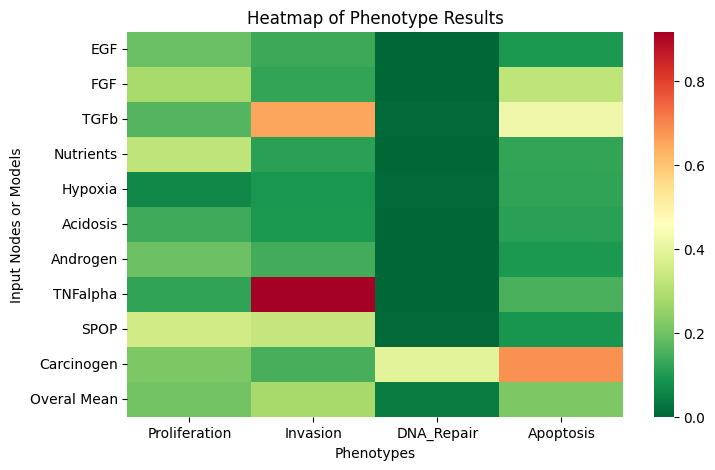

In [8]:


plt.figure(figsize=(8, 5))
results_phenotypes_numeric = results_phenotypes.apply(pd.to_numeric, errors='coerce')
sns.heatmap(results_phenotypes_numeric, annot=False, cmap="RdYlGn_r")
plt.title("Heatmap of Phenotype Results")
plt.xlabel("Phenotypes")
plt.ylabel("Input Nodes or Models")

# Save as high-resolution PDF
plt.savefig("analysis/generic_models/results/heatmap_phenotypes.png", dpi=400, bbox_inches='tight')  

plt.show()



In [ ]:
model_generic_zero = maboss.load(bnd_template_path,cfg_template_path)
# generic_model = model_generic.run()


for node in inputs_list:
    model_generic_zero.network.set_istate(node, [1, 0])

generic_model_zero = model_generic_zero.run()
generic_model_zero.plot_piechart()

fig = plt.gcf()

fig.savefig("analysis/generic_models/results/piechart_generic_model_zero.pdf", format='pdf', dpi=400, bbox_inches='tight')


NameError: name 'input_nodes' is not defined

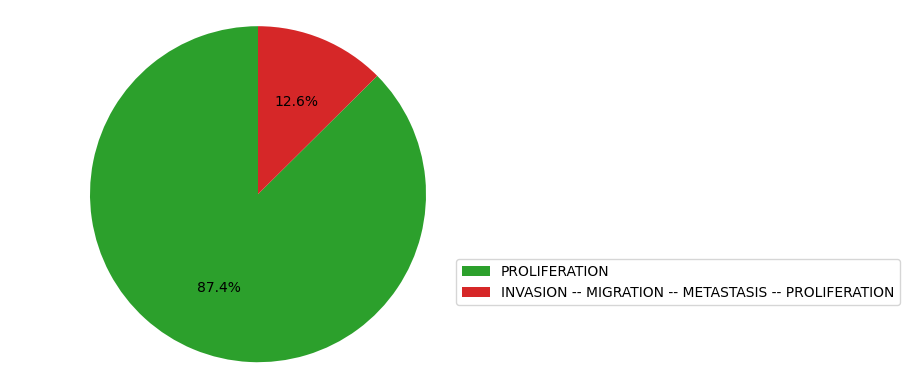

In [ ]:
model_generic_zero_egf_nutrients = model_generic_zero.copy()

model_generic_zero_egf_nutrients.network.set_istate('EGF', [0, 1])
model_generic_zero_egf_nutrients.network.set_istate('NUTRIENTS', [0, 1])
generic_model_egf_nutrients = model_generic_zero_egf_nutrients.run()

generic_model_egf_nutrients.plot_piechart()

fig = plt.gcf()


fig.savefig("analysis/generic_models/results/piechart_generic_egf_nutrients.pdf", format='pdf', dpi=400, bbox_inches='tight')


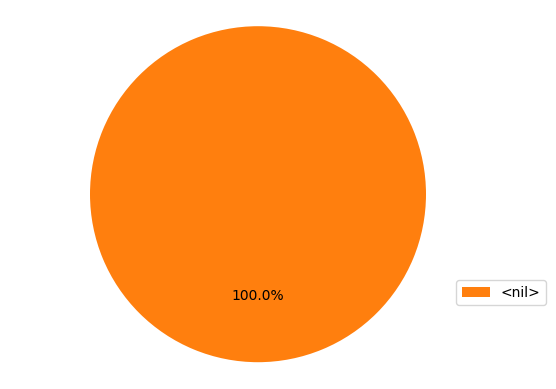

In [ ]:
model_generic_zero_egf_nutrients_myc_mut = model_generic_zero_egf_nutrients.copy()
model_generic_zero_egf_nutrients_myc_mut.mutate("MYC_MAX", "OFF")
res_mutant_generic_growth_myc_mut = model_generic_zero_egf_nutrients_myc_mut.run()
res_mutant_generic_growth_myc_mut.plot_piechart()

fig = plt.gcf()

fig.savefig("analysis/generic_models/results/piechart_generic_growth_myc_mut.pdf", format='pdf', dpi=400, bbox_inches='tight')



Results

- similar results as the paper
- TGFB can act as both an oncogene and tumor suppressor
- When Carcinogen is present this increase genome instability and DNA damage (DNA repair is a sensor of DNA damage)